# Unsupervised Learning

## Introduction

*Unsupervised learning* refers to techniques where we do not give the algorithm a target output (e.g. a set of expected classifications of the data). Instead, the algorithm must interpret the data and draw some kind of conclusion entirely on its own, without any supervision from us.

Unsupervised learning is particularly attractive in the context of monitoring because it has the potential to notice and determine trends that would go unrecognised by a human operator. Example applications include:
* Time series anomaly detection
* Detection of abnormal events in logs
* Predictive models (e.g. Google's learned PUE model https://docs.google.com/a/google.com/viewer?url=www.google.com/about/datacenters/efficiency/internal/assets/machine-learning-applicationsfor-datacenter-optimization-finalv2.pdf) (TODO: is this supervised or unsupervised?

For this workshop, we'll be focusing on a simple example of time series anomaly detection. Our algorithm will be based on an approach that attempts to reconstruct a waveform using the wave patterns that it has seen before. If the reconstruction is poor, then the waveform is likely of a form that the algorithm hasn't seen before, and therefore is anomalous. TODO: is this really unsupervised? We're still giving it some idea of what's "normal", right?

The example is based on Chapter 4, *More Complex, Adaptive Models* from [Practical Machine Learning](https://www.safaribooksonline.com/library/view/practical-machine-learning/9781491914151/ch04.html).

## Anomaly Detection

In the context of time series data, we can define an "anomaly" as simply being some pattern in the data that we haven't seen before.

In some cases, we may be able to detect such novel patterns by merely looking for any values beyond a certain threshold:

TODO add image

In other cases, though, the structure of the waveform may prevent detection of anomalies using this method:

And more subtle errors - a change in the shape of a periodic waveform, for examples - will be simply impossible to pick up with such a method:

TODO add image

What we want more generally is a method that can learn what constitutes a "normal" waveform not just in terms of its instantaneous value in terms of its *shape*.

### Clustering

Let us take a step back from our problem and have a look at a simpler example to demonstrate how we might go about determining what constitutes a sense of what is "normal".

Suppose we are manufacturing power supplies. Our power supplies use capacitors from two different manufacturers. During the QA phase, for each  power supply sample we measure two variables: power efficiency and voltage ripple. We could plot a graph of one variable against another to get a sense of the distribution of the data:

TODO add image with two clusters

These two variables, of course, have absolute limits, as shown by the box on the graph. Within these limits, however, we find that the data tends to form two groups, or *clusters*, depending on which type of capacitor is used.

Suppose the next power supply that comes off the assembly line meets the *absolute* requirements (falls within the box on the graph), but falls a way outside either group:

TODO image

We detect this anomaly by the fact that it lies outside of either of these clusters. Here our clusters were defined in a two-dimensional space defined by two variables (or two *features*, in machine learning parlance); but the approach is generalisable to three-dimensional space, defined by three features:

TODO image

Or an *n*-dimensional space, defined by *n* features. (The general case is a little harder to visualise - so just stick with the three-dimensional case and pretend there are more dimensions.)

Machine learning algorithms exist to identify such clusters automatically. The particular method we'll be using is called the *k-means clustering* algorithm.

### Waveform Space

The first step in applying such a technique to waveforms would be defining the space in which clusters will be formed. We can split the waveform into chunks to give us separate "samples", but what will our *features* be - what are the variables that will define the *n*-dimensional space?

We could go with measurements of each chunk such as maximum, minimum and spread. But since our technique is generalisable to any number of dimensions, we can do something a bit more clever: we can take each element of the chunk as a separate dimension. For a chunk containing 32 instantaneous values, we define a 32-dimensional space in which to form our clusters.

### Waveform Anomaly Detection

In the example of the power supplies, we detected anomalous samples based on the distance from clusters. For our waveform example, we're going to do something a little bit different, which lends itself more easily to visualisation.

Consider the clusters in *n*-dimensional space again. Similar chunks will cluster together. The middle of each cluster (the *centroid*) will then provide some measure of the prototypical waveform pattern that all those chunks are specific instances of. (If this is difficult to visualise, the other way to consider it is that the centroid is simply the mean of all waveform samples in that cluster.)

Note that the centroid, being a point in the waveform space, is itself a waveform. Thus, the cluster centroids provide us with a set of "normal" waveform chunks.

Suppose we then try to reconstruct a novel set of data using our standard "normal" chunks. If the data is similar in shape to what has come before it, we will be able to manage to good reconstruction. However, if the data contains some abnormal shape, we will not be able to reconstruct it using our normal shape library, and we will get a reconstruction error. This error will indicate an anomaly!

In summary, our algorithm will be:

**Training**:

* Split training waveform data into chunks of *n* samples
* Form a space in *n* dimensions, with each chunk representing one point
* Cluster the chunk points, and determine the centres or *centroids* of the clusters
* Cluster centroids provide library of "normal" waveform shapes

**Testing**:

* Try to reconstruct waveform data to be testing using cluster centroids obtained from testing data set
* Poor reconstruction error on any individual chunk indicates anomalous shape

## Our Data Set

To explore anomaly detection, we'll be using an EKG data set from [PhysioNet](http://physionet.org/physiobank/database/apnea-ecg/). Since this data has a very regular waveform, it provides a good vehicle for us to explore the algorithms without getting bogged down in the complications that come with real-world data.

The data is supplied in the `a02.dat` file. A Python module `ekg_data.py` is provided to read the data.

## Exploring the Data

Let's get started by importing the EKG data module and examining what the data looks like:

In [26]:
from __future__ import print_function
import ekg_data

ekg_filename = 'a02.dat'
ekg_data = ekg_data.read_ekg_data(ekg_filename)
print(ekg_data.shape)

(3182000,)


Since there's rather a lot of the data, we're only going to take the first 10,000 values, so that our examples run a bit quicker.

In [ ]:
ekg_data = ekg_data[0:10000]

The data is provided as a one-dimensional list (or *vector*) of floating-point samples:

In [24]:
print("ekg_data[0]:\t", ekg_data[0])
print("ekg_data[1]:\t", ekg_data[1])
print("ekg_data.min:\t", ekg_data.min())
print("ekg_data.max:\t", ekg_data.max())

ekg_data[0]:	 -4.0
ekg_data[1]:	 -4.0
ekg_data.min:	 -572.0
ekg_data.max:	 580.0


We can also plot a number of samples from the data to get a feel for the waveform:

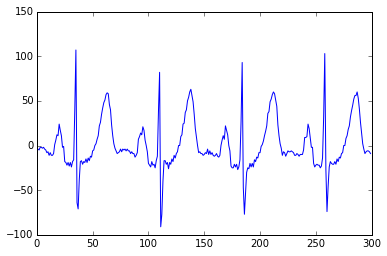

In [23]:
# IPython 'magic' command to set the matplotlib backend to display
# in the notebook
%matplotlib inline

import matplotlib.pyplot as plt

n_samples_to_plot = 300
plt.plot(ekg_data[0:n_samples_to_plot])
plt.show()
# TODO: add axis labels

## Windowing

The first step in our anomaly detection algorithm is to split the waveform into chunks (OR RATHER SAMPLES TODO). Our chunks will overlap. TODO make faster

In [35]:
import numpy as np

chunks = []
chunk_len = 32
slide_len = 2
for start_pos in range(0, len(ekg_data), slide_len):
    end_pos = start_pos + chunk_len
    chunk = np.copy(ekg_data[start_pos:end_pos])
    # if we're at the end and we've got a truncated chunk,
    # drop it
    if len(chunk) != chunk_len:
        continue
    chunks.append(chunk)

print(len(chunks))

1590985


Let's take a look at the chunks we've produced:

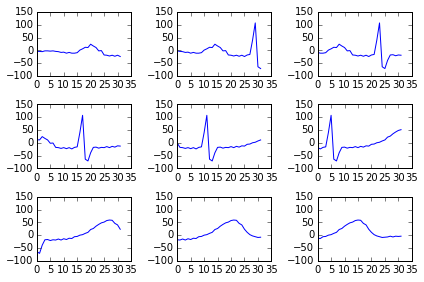

In [33]:
def plot_chunks(chunks):
    plt.figure()
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    chunk_n = 0
    for row in range(n_graph_rows):
        for col in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            axes.set_ylim([-100, 150])
            plt.plot(chunks[chunk_n])
            graph_n += 1
            chunk_n += 3
    # fix subplot sizes so that everything fits
    plt.tight_layout()
    plt.show()

plot_chunks(chunks)

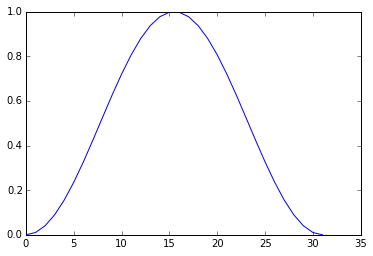

In [32]:
window_rads = np.linspace(0, np.pi, chunk_len)
window = np.sin(window_rads)**2
plt.plot(window)

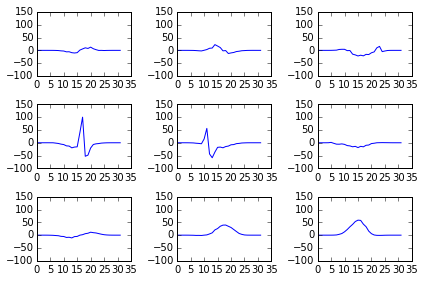

In [38]:
for chunk in chunks:
    chunk *= window
plot_chunks(chunks)

TODO: normalise?

## Clustering

## Reconstruction from Clusters

## Anomaly Detection

https://class.coursera.org/ml-003/lecture/78 for k-means